# ANALYSIS OF WEATHER DATA

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import difflib
import requests
import io
import numpy as np
from scipy.stats import pearsonr, f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [42]:
file_path = '../data/GlobalWeatherRepository.csv'
file_path_2 = '../data/life_expectancy_at_birth_years.csv'

df = pd.read_csv(file_path)
df2 = pd.read_csv(file_path_2)

print(df.head())
print(df.info())

print(df2.head())
print(df2.info())


       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    66.2  Partly cloudy

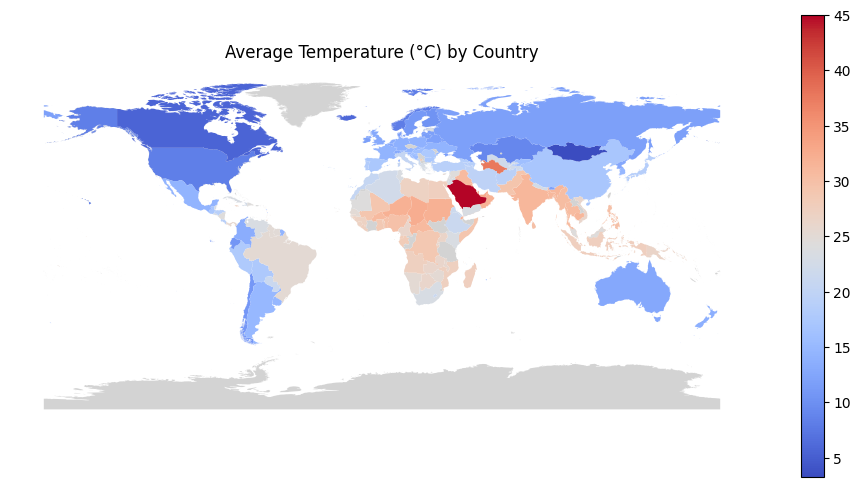

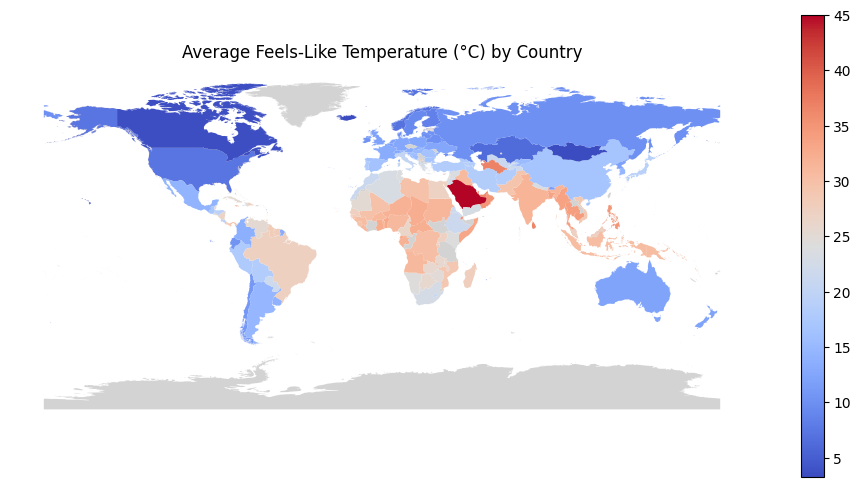

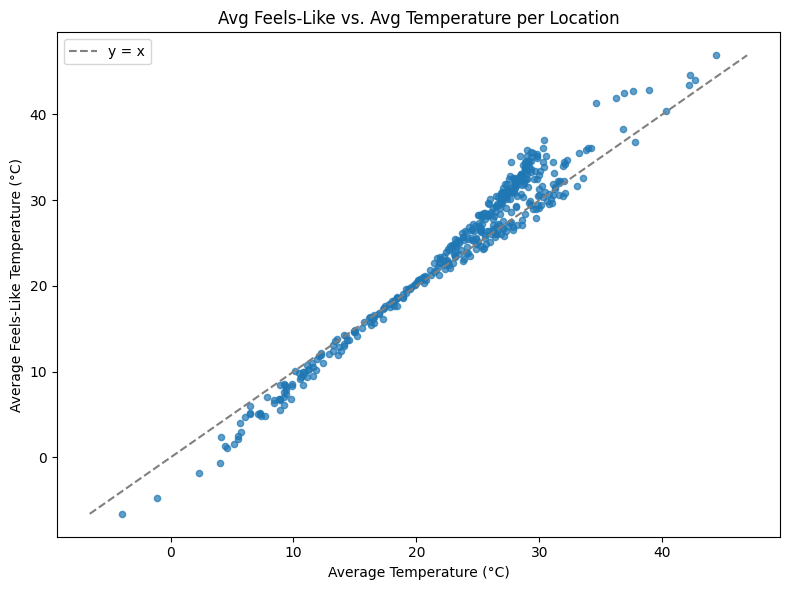

In [57]:

country_avg = df.groupby('country')[['temperature_celsius', 'feels_like_celsius']].mean().reset_index()

try:
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
except Exception:
    url = "https://datahub.io/core/geo-countries/r/countries.geojson"
    try:
        # Laden in-memory
        r = requests.get(url)
        r.raise_for_status()
        world = gpd.read_file(io.StringIO(r.text))
    except Exception as e:
        raise RuntimeError(f"Konnte Weltkarte nicht laden: {e}")

world_names = world['NAME'].tolist() if 'NAME' in world.columns else world['name'].tolist()
# Manche GeoJSON haben Property 'ADMIN' oder 'NAME'; wir prüfen:
if 'name' in world.columns:
    key_name = 'name'
elif 'NAME' in world.columns:
    key_name = 'NAME'
elif 'ADMIN' in world.columns:
    key_name = 'ADMIN'
else:
    key_name = world.columns[0]  # notfalls erste Spalte

world_names = world[key_name].tolist()
unique_countries = country_avg['country'].unique()

mapping = {}
for cname in unique_countries:
    matches = difflib.get_close_matches(cname, world_names, n=1, cutoff=0.8)
    if matches:
        mapping[cname] = matches[0]
    else:
        mapping[cname] = None

country_avg['country_norm'] = country_avg['country'].map(mapping)

merged = world.merge(country_avg, how='left', left_on=key_name, right_on='country_norm')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
vmin = country_avg['temperature_celsius'].min()
vmax = country_avg['temperature_celsius'].max()
merged.plot(
    column='temperature_celsius',
    ax=ax,
    legend=True,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
ax.set_title('Average Temperature (°C) by Country')
ax.set_axis_off()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
merged.plot(
    column='feels_like_celsius',
    ax=ax,
    legend=True,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
ax.set_title('Average Feels-Like Temperature (°C) by Country')
ax.set_axis_off()
plt.show()

loc_avg = df.groupby(['latitude', 'longitude'])[['temperature_celsius', 'feels_like_celsius']].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.scatter(
    loc_avg['temperature_celsius'],
    loc_avg['feels_like_celsius'],
    s=20,
    alpha=0.7
)
min_val = min(loc_avg['temperature_celsius'].min(), loc_avg['feels_like_celsius'].min())
max_val = max(loc_avg['temperature_celsius'].max(), loc_avg['feels_like_celsius'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', label='y = x')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Average Feels-Like Temperature (°C)')
plt.title('Avg Feels-Like vs. Avg Temperature per Location')
plt.legend()
plt.tight_layout()
plt.show()

Top Wetterbedingungen für Analyse: ['Partly cloudy', 'Sunny', 'Patchy rain nearby', 'Partly Cloudy', 'Overcast', 'Clear', 'Mist', 'Light rain', 'Light rain shower', 'Fog', 'Cloudy', 'Moderate or heavy rain with thunder', 'Moderate rain']


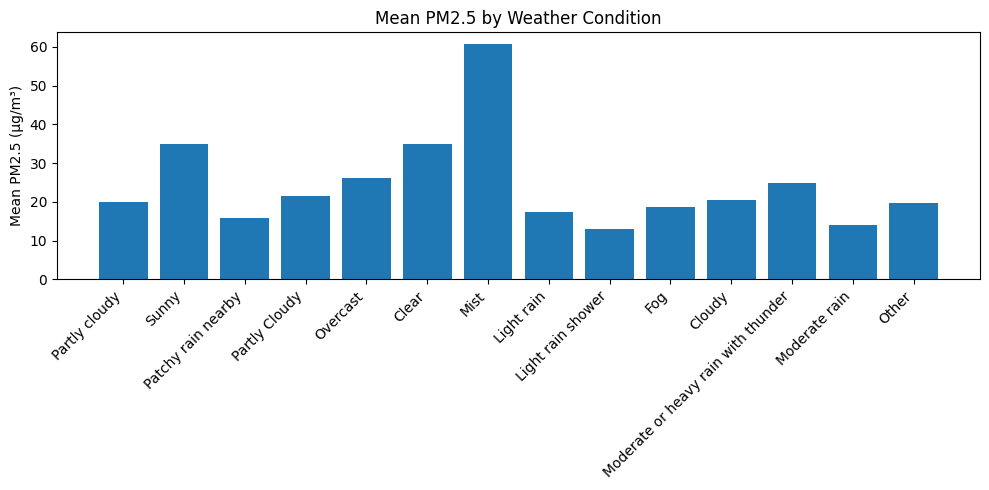

In [26]:
required_cols = ['condition_text', 'air_quality_PM2.5', 'wind_kph']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Spalte '{col}' nicht im DataFrame gefunden")

condition_counts = df['condition_text'].value_counts()
threshold = 500
top_conditions = condition_counts[condition_counts >= threshold].index.tolist()
print("Top Wetterbedingungen für Analyse:", top_conditions)

df['condition_group'] = df['condition_text'].where(df['condition_text'].isin(top_conditions), 'Other')

mean_pm = df.groupby('condition_group')['air_quality_PM2.5'].mean().loc[labels]
plt.figure(figsize=(10, 5))
plt.bar(labels, mean_pm)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean PM2.5 (µg/m³)')
plt.title('Mean PM2.5 by Weather Condition')
plt.tight_layout()
plt.show()


Keine automatische Übereinstimmung für: ['Bahamas', 'Brunei Darussalam', 'Bélgica', 'Congo', 'Czech Republic', 'Fiji Islands', 'Inde', 'Komoren', "Lao People's Democratic Republic", 'Letonia', 'Macedonia', 'Marrocos', 'Mexique', 'Micronesia', 'Polônia', 'Saint-Vincent-et-les-Grenadines', 'Serbia', 'Seychelles Islands', 'Swaziland', 'Südkorea', 'Tanzania', 'Timor-Leste', 'Vatican City', 'Гватемала', 'Польша', 'Турция', 'كولومبيا', '火鸡']


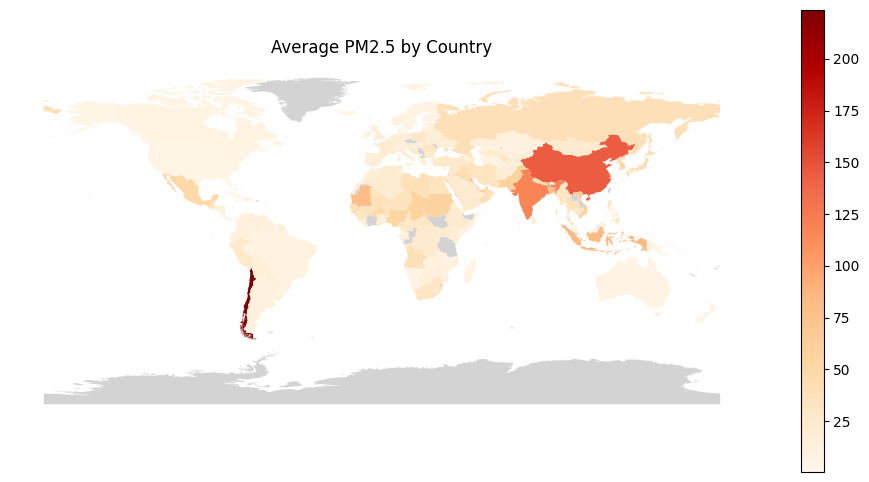

In [25]:
country_avg = df.groupby('country')['air_quality_PM2.5'].mean().reset_index()

try:
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
except Exception:
    url = "https://datahub.io/core/geo-countries/r/countries.geojson"
    r = requests.get(url)
    r.raise_for_status()
    world = gpd.read_file(io.StringIO(r.text))

if 'name' in world.columns:
    key_name = 'name'
elif 'NAME' in world.columns:
    key_name = 'NAME'
elif 'ADMIN' in world.columns:
    key_name = 'ADMIN'
else:
    key_name = world.columns[0]

world_names = world[key_name].tolist()
unique_countries = country_avg['country'].unique()
mapping = {}
for cname in unique_countries:
    match = difflib.get_close_matches(cname, world_names, n=1, cutoff=0.8)
    mapping[cname] = match[0] if match else None

no_match = [c for c, m in mapping.items() if m is None]
if no_match:
    print("Keine automatische Übereinstimmung für:", no_match)


country_avg['country_norm'] = country_avg['country'].map(mapping)
merged = world.merge(country_avg, how='left', left_on=key_name, right_on='country_norm')

vmin = country_avg['air_quality_PM2.5'].min()
vmax = country_avg['air_quality_PM2.5'].max()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
merged.plot(
    column='air_quality_PM2.5',
    ax=ax,
    legend=True,
    cmap='OrRd',
    vmin=vmin,
    vmax=vmax,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
ax.set_title('Average PM2.5 by Country')
ax.set_axis_off()
plt.show()

Correlation Temperature vs. PM2.5: r=-0.02, p=0.000
Correlation Temperature vs. PM10: r=0.07, p=0.000


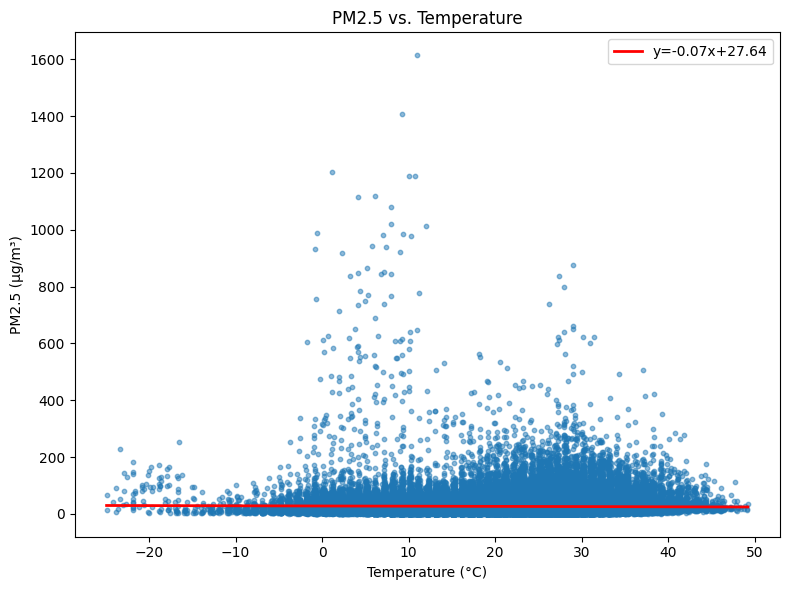

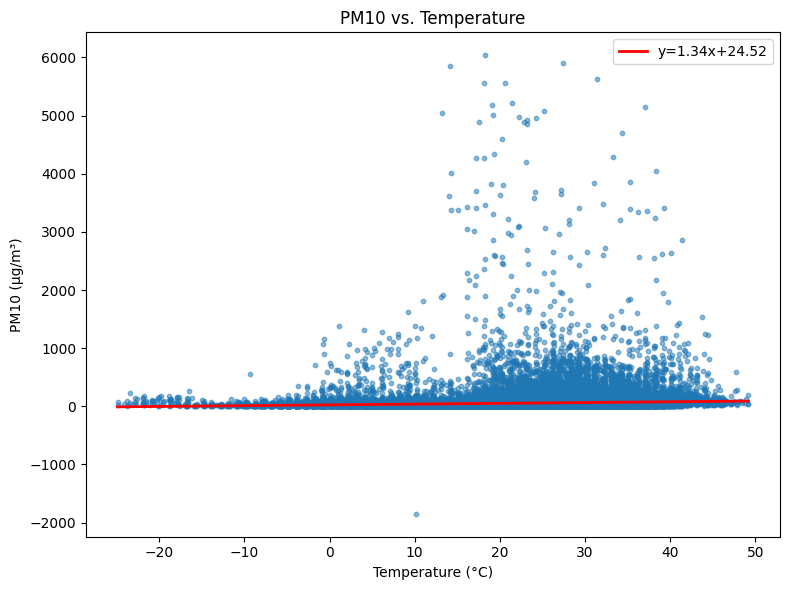

C:\Users\ChambergZelimchanow\AppData\Local\Temp\ipykernel_9032\4268964419.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df_bins.groupby('temp_bin')[['air_quality_PM2.5', 'air_quality_PM10']].mean()
C:\Users\ChambergZelimchanow\AppData\Local\Temp\ipykernel_9032\4268964419.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_bins.groupby('temp_bin')['temperature_celsius'].mean()


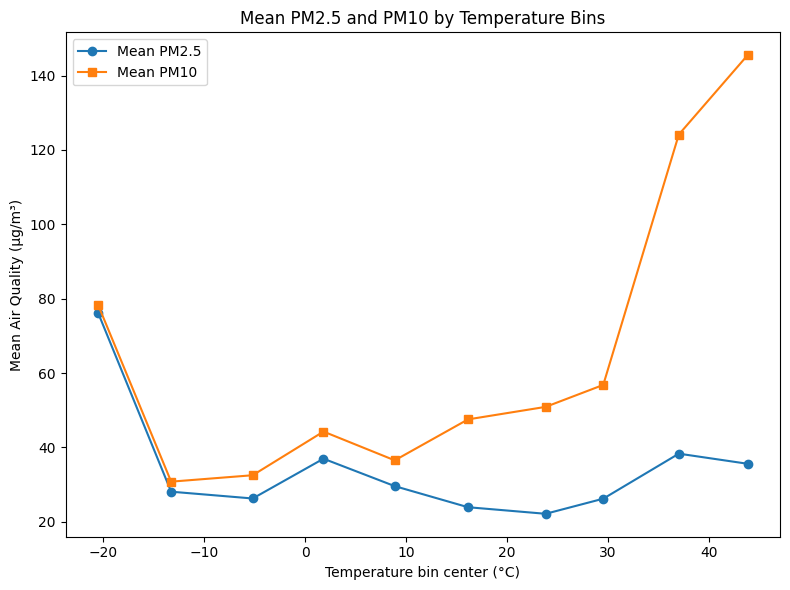

In [56]:
required_cols = ['temperature_celsius', 'air_quality_PM2.5', 'air_quality_PM10']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Spalte '{col}' nicht im DataFrame gefunden")

x = df['temperature_celsius']
pm25 = df['air_quality_PM2.5']
pm10 = df['air_quality_PM10']

mask25 = x.notna() & pm25.notna()
mask10 = x.notna() & pm10.notna()

if mask25.sum() > 1:
    corr25, p25 = pearsonr(x[mask25], pm25[mask25])
    print(f"Correlation Temperature vs. PM2.5: r={corr25:.2f}, p={p25:.3f}")
else:
    print("Nicht genügend Daten für Korrelation Temperature vs. PM2.5")

if mask10.sum() > 1:
    corr10, p10 = pearsonr(x[mask10], pm10[mask10])
    print(f"Correlation Temperature vs. PM10: r={corr10:.2f}, p={p10:.3f}")
else:
    print("Nicht genügend Daten für Korrelation Temperature vs. PM10")

def scatter_with_trend(x_data, y_data, xlabel, ylabel, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(x_data, y_data, s=10, alpha=0.5)
    if len(x_data) > 1:
        m, b = np.polyfit(x_data, y_data, deg=1)
        x_vals = np.linspace(x_data.min(), x_data.max(), 100)
        plt.plot(x_vals, m * x_vals + b, color='red', linewidth=2, label=f'y={m:.2f}x+{b:.2f}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

scatter_with_trend(x[mask25], pm25[mask25], 'Temperature (°C)', 'PM2.5 (µg/m³)', 'PM2.5 vs. Temperature')
scatter_with_trend(x[mask10], pm10[mask10], 'Temperature (°C)', 'PM10 (µg/m³)', 'PM10 vs. Temperature')

num_bins = 10
df_bins = df[['temperature_celsius', 'air_quality_PM2.5', 'air_quality_PM10']].dropna()
df_bins['temp_bin'] = pd.cut(df_bins['temperature_celsius'], bins=num_bins)

bin_stats = df_bins.groupby('temp_bin')[['air_quality_PM2.5', 'air_quality_PM10']].mean()
bin_centers = df_bins.groupby('temp_bin')['temperature_celsius'].mean()

plt.figure(figsize=(8, 6))
plt.plot(bin_centers, bin_stats['air_quality_PM2.5'], marker='o', label='Mean PM2.5')
plt.plot(bin_centers, bin_stats['air_quality_PM10'], marker='s', label='Mean PM10')
plt.xlabel('Temperature bin center (°C)')
plt.ylabel('Mean Air Quality (µg/m³)')
plt.title('Mean PM2.5 and PM10 by Temperature Bins')
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\ChambergZelimchanow\AppData\Local\Temp\ipykernel_9032\2405364286.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precip_prob_humidity = df.groupby(humidity_bins).apply(lambda g: (g['precip_mm'] > 0).mean()).reset_index(name='precip_prob')
C:\Users\ChambergZelimchanow\AppData\Local\Temp\ipykernel_9032\2405364286.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precip_mean_humidity = df.groupby(humidity_bins)['precip_mm'].mean().reset_index(name='precip_mean')
C:\Users\ChambergZelimchanow\AppData\Local\Temp\ipykernel_9032\2405364286.py:15: FutureWarning: The default of observed=False is deprecat


Precipitation probability and mean by Humidity bins:
        humidity  precip_prob  precip_mean
0  (1.902, 11.8]     0.002306     0.000146
1   (11.8, 21.6]     0.013674     0.000838
2   (21.6, 31.4]     0.048298     0.005860
3   (31.4, 41.2]     0.072597     0.013653
4   (41.2, 51.0]     0.154970     0.031868
5   (51.0, 60.8]     0.242158     0.065635
6   (60.8, 70.6]     0.340934     0.096904
7   (70.6, 80.4]     0.500425     0.154931
8   (80.4, 90.2]     0.526600     0.250738
9  (90.2, 100.0]     0.541354     0.373241


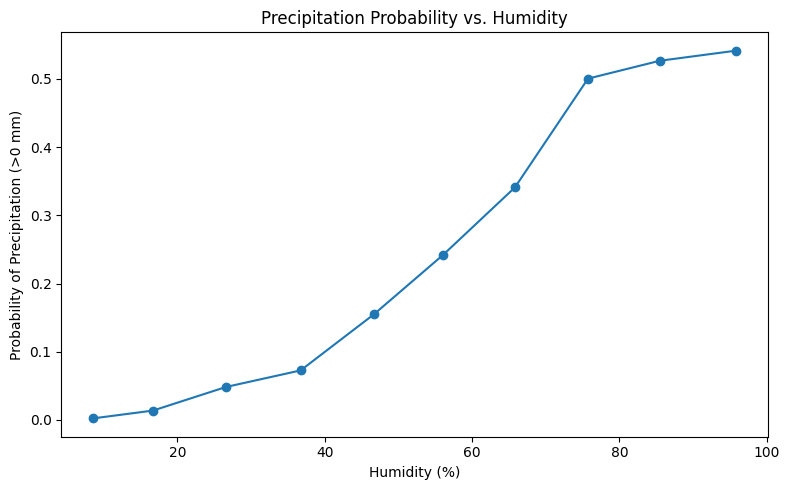

C:\Users\ChambergZelimchanow\AppData\Local\Temp\ipykernel_9032\2405364286.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precip_prob_cloud = df.groupby(cloud_bins).apply(lambda g: (g['precip_mm'] > 0).mean()).reset_index(name='precip_prob')
C:\Users\ChambergZelimchanow\AppData\Local\Temp\ipykernel_9032\2405364286.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precip_mean_cloud = df.groupby(cloud_bins)['precip_mm'].mean().reset_index(name='precip_mean')
C:\Users\ChambergZelimchanow\AppData\Local\Temp\ipykernel_9032\2405364286.py:32: FutureWarning: The default of observed=False is deprecated and wil


Precipitation probability and mean by Cloud cover bins:
           cloud  precip_prob  precip_mean
0   (-0.1, 10.0]     0.033008     0.008356
1   (10.0, 20.0]     0.000000     0.000000
2   (20.0, 30.0]     0.244923     0.076590
3   (30.0, 40.0]     0.119163     0.044952
4   (40.0, 50.0]     0.400790     0.140890
5   (50.0, 60.0]     0.622751     0.272397
6   (60.0, 70.0]     0.744247     0.311631
7   (70.0, 80.0]     0.635538     0.255049
8   (80.0, 90.0]     0.921063     0.341673
9  (90.0, 100.0]     0.607104     0.413586


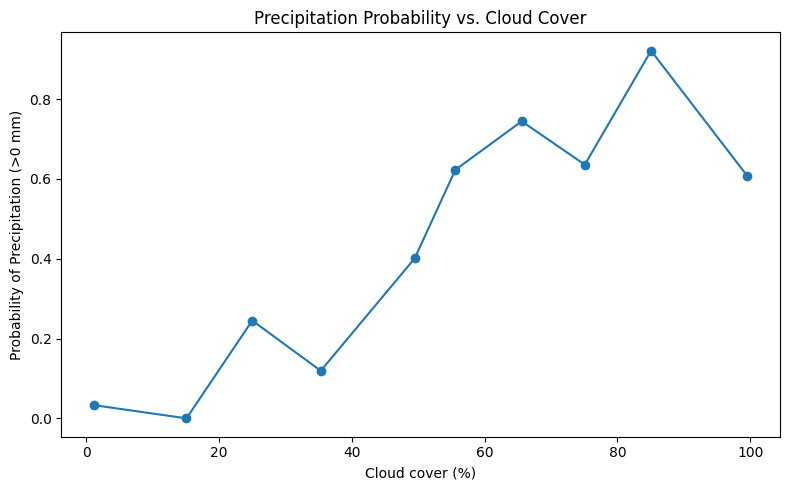

In [55]:
required_cols = ['humidity', 'cloud', 'precip_mm']
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Spalte '{col}' nicht im DataFrame gefunden")


humidity_bins = pd.cut(df['humidity'], bins=10)
precip_prob_humidity = df.groupby(humidity_bins).apply(lambda g: (g['precip_mm'] > 0).mean()).reset_index(name='precip_prob')
precip_mean_humidity = df.groupby(humidity_bins)['precip_mm'].mean().reset_index(name='precip_mean')
humidity_summary = precip_prob_humidity.merge(precip_mean_humidity, on='humidity')

print("\nPrecipitation probability and mean by Humidity bins:")
print(humidity_summary)

bin_centers_h = df.groupby(humidity_bins)['humidity'].mean().reset_index(name='humidity_center')
plt.figure(figsize=(8, 5))
plt.plot(bin_centers_h['humidity_center'], humidity_summary['precip_prob'], marker='o')
plt.xlabel('Humidity (%)')
plt.ylabel('Probability of Precipitation (>0 mm)')
plt.title('Precipitation Probability vs. Humidity')
plt.tight_layout()
plt.show()

cloud_bins = pd.cut(df['cloud'], bins=10)
precip_prob_cloud = df.groupby(cloud_bins).apply(lambda g: (g['precip_mm'] > 0).mean()).reset_index(name='precip_prob')
precip_mean_cloud = df.groupby(cloud_bins)['precip_mm'].mean().reset_index(name='precip_mean')
cloud_summary = precip_prob_cloud.merge(precip_mean_cloud, on='cloud')

print("\nPrecipitation probability and mean by Cloud cover bins:")
print(cloud_summary)

bin_centers_c = df.groupby(cloud_bins)['cloud'].mean().reset_index(name='cloud_center')
plt.figure(figsize=(8, 5))
plt.plot(bin_centers_c['cloud_center'], cloud_summary['precip_prob'], marker='o')
plt.xlabel('Cloud cover (%)')
plt.ylabel('Probability of Precipitation (>0 mm)')
plt.title('Precipitation Probability vs. Cloud Cover')
plt.tight_layout()
plt.show()

Keine automatische Übereinstimmung für folgende Wetter-Länder: ['Andorra', 'Bolivia', 'Bélgica', 'Czech Republic', 'Dominica', 'Fiji Islands', 'Inde', 'Iran', 'Komoren', 'Kosovo', 'Letonia', 'Liechtenstein', 'Macedonia', 'Marrocos', 'Marshall Islands', 'Mexique', 'Micronesia', 'Monaco', 'Netherlands', 'North Korea', 'Palau', 'Polônia', 'Russia', 'Saint Kitts and Nevis', 'Saint-Vincent-et-les-Grenadines', 'San Marino', 'Seychelles Islands', 'South Korea', 'Swaziland', 'Syria', 'Südkorea', 'Tanzania', 'Turkey', 'Tuvalu', 'United Kingdom', 'Vatican City', 'Venezuela', 'Гватемала', 'Польша', 'Турция', 'كولومبيا', '火鸡']
Anzahl gematchte Länder: 168
Correlation air_quality_PM2.5 vs. Life Expectancy: r=0.01, p=0.939
Correlation air_quality_PM10 vs. Life Expectancy: r=-0.02, p=0.804


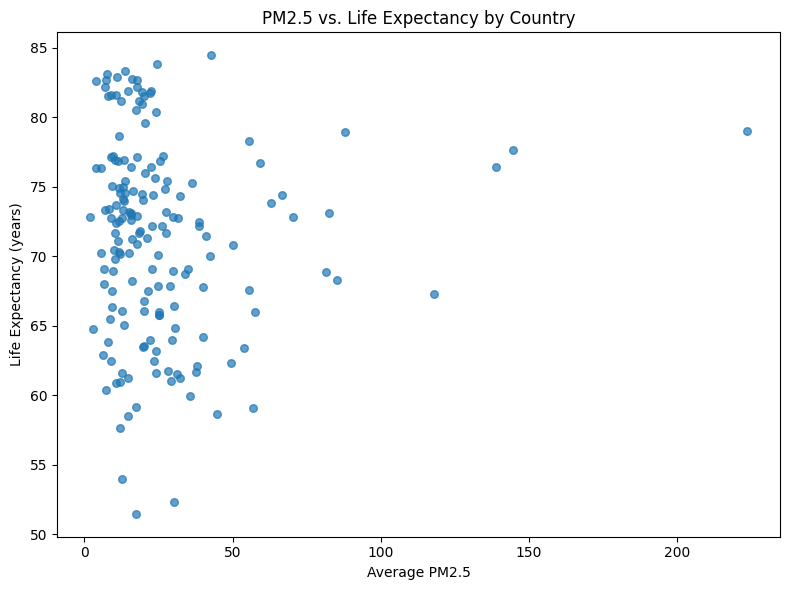

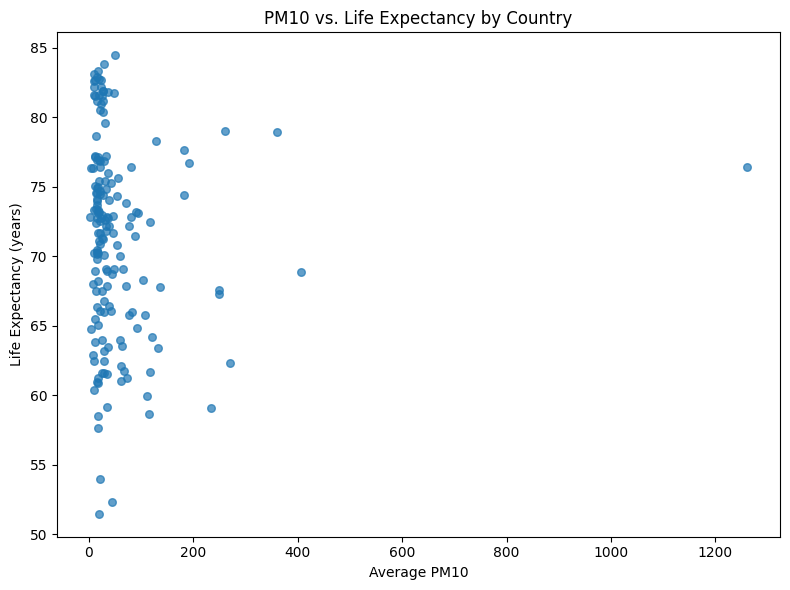

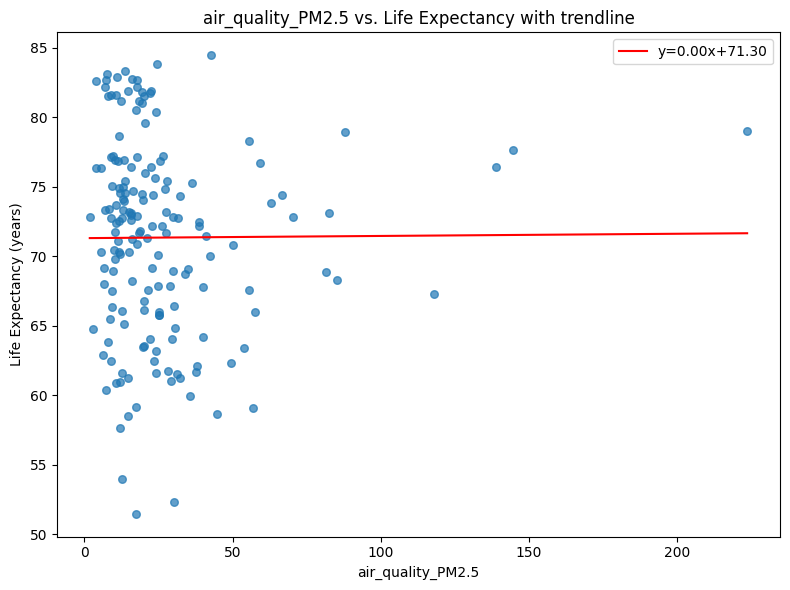

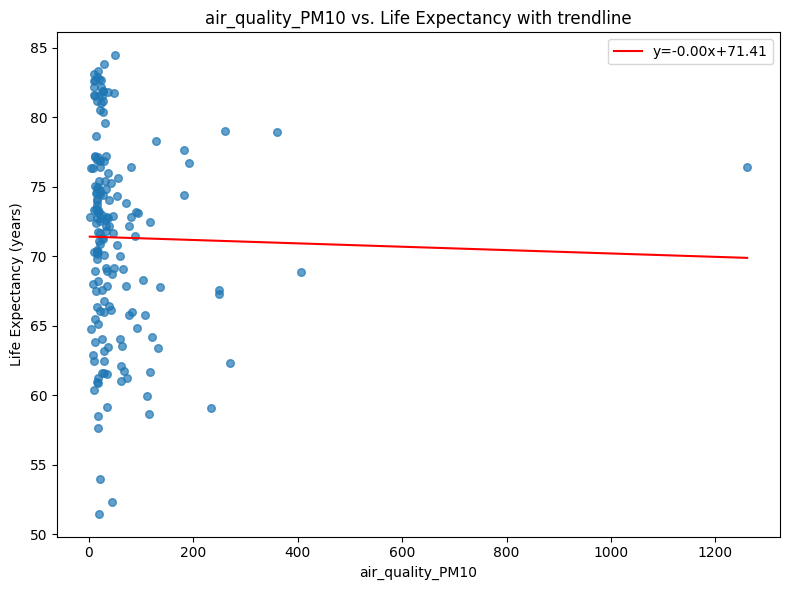

In [54]:
required_le_cols = ['Location', 'Period', 'FactValueNumeric', 'IsLatestYear']
for col in required_le_cols:
    if col not in df2.columns:
        raise ValueError(f"Spalte '{col}' nicht in Lebenserwartungs-Daten gefunden")

if 'IsLatestYear' in df2.columns:
    df2_recent = df2[df2['IsLatestYear'] == True].copy()
else:
    df2_recent = df2.sort_values('Period').groupby('Location', as_index=False).last()

df2_recent = df2_recent[['Location', 'FactValueNumeric']].rename(
    columns={'Location': 'location_le', 'FactValueNumeric': 'life_expectancy'}
)

if 'country' not in df.columns:
    raise ValueError("Wetterdaten enthalten keine Spalte 'country'")
weather_avg = df.groupby('country')[['air_quality_PM2.5', 'air_quality_PM10']].mean().reset_index().rename(
    columns={'country': 'location_w'})
weather_avg = weather_avg.rename(columns={'location_w': 'country_weather'})

locations_le = df2_recent['location_le'].unique().tolist()
countries_w = weather_avg['country_weather'].unique().tolist()

mapping = {}
for cw in countries_w:
    # Suche bestes Match in Lebenserwartungs-Locations
    match = difflib.get_close_matches(cw, locations_le, n=1, cutoff=0.8)
    mapping[cw] = match[0] if match else None

no_match = [cw for cw, lm in mapping.items() if lm is None]
if no_match:
    print("Keine automatische Übereinstimmung für folgende Wetter-Länder:", no_match)

weather_avg['location_le'] = weather_avg['country_weather'].map(mapping)
df_merge = weather_avg.dropna(subset=['location_le']).merge(
    df2_recent,
    on='location_le',
    how='inner'
)

print(f"Anzahl gematchte Länder: {df_merge.shape[0]}")

for pm_col in ['air_quality_PM2.5', 'air_quality_PM10']:
    x = df_merge[pm_col]
    y = df_merge['life_expectancy']
    mask = x.notna() & y.notna()
    if mask.sum() > 1:
        corr, p = pearsonr(x[mask], y[mask])
        print(f"Correlation {pm_col} vs. Life Expectancy: r={corr:.2f}, p={p:.3f}")
    else:
        print(f"Nicht genügend Daten für Korrelation {pm_col} vs. Life Expectancy")

plt.figure(figsize=(8, 6))
plt.scatter(df_merge['air_quality_PM2.5'], df_merge['life_expectancy'], alpha=0.7, s=30)
plt.xlabel('Average PM2.5')
plt.ylabel('Life Expectancy (years)')
plt.title('PM2.5 vs. Life Expectancy by Country')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df_merge['air_quality_PM10'], df_merge['life_expectancy'], alpha=0.7, s=30)
plt.xlabel('Average PM10')
plt.ylabel('Life Expectancy (years)')
plt.title('PM10 vs. Life Expectancy by Country')
plt.tight_layout()
plt.show()

import numpy as np
for pm_col in ['air_quality_PM2.5', 'air_quality_PM10']:
    x = df_merge[pm_col].values
    y = df_merge['life_expectancy'].values
    if len(x) > 1:
        m, b = np.polyfit(x, y, 1)
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, alpha=0.7, s=30)
        x_vals = np.linspace(np.min(x), np.max(x), 100)
        plt.plot(x_vals, m*x_vals + b, color='red', label=f'y={m:.2f}x+{b:.2f}')
        plt.xlabel(pm_col)
        plt.ylabel('Life Expectancy (years)')
        plt.title(f'{pm_col} vs. Life Expectancy with trendline')
        plt.legend()
        plt.tight_layout()
        plt.show()
